In [1]:
# make 3D rotate
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from functools import partial
from scipy.optimize import curve_fit
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

# Data Wrangling

In [2]:
# BS-calculator
N = norm.cdf

def BS_CALL(S, K, T, r, q, sigma):
    if sigma * np.sqrt(T) != 0.0:
        d1 = (np.log(S/K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(-q*T) * N(d1) - K * np.exp(-r*T) * N(d2)
    else:
        return S * np.exp(-q*T)

def BS_PUT(S, K, T, r, q, sigma):
    if sigma * np.sqrt(T) != 0.0:
        d1 = (np.log(S/K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return K * np.exp(-r*T) * N(-d2) - S * np.exp(-q*T) * N(-d1)
    else:
        return K * np.exp(-r*T)

# dataframe is each row
def BS(dataframe):
    S = dataframe['adj_close']
    K = dataframe['strike']
    T = dataframe['expiration_days'] / 365
    r = dataframe['disc_rate']
    q = dataframe['div_yield']
    sigma = dataframe['implied_vol']
    CP = dataframe['call/put']
    if CP == 'C':
        return BS_CALL(S, K, T, r, q, sigma)
    elif CP == 'P':
        return BS_PUT(S, K, T, r, q, sigma)
    else:
        return None

def BS_vol(dataframe):
    S = dataframe['adj_close']
    K = dataframe['strike']
    T = dataframe['expiration_days'] / 365
    r = dataframe['disc_rate']
    q = dataframe['div_yield']
    price = (dataframe['best_bid'] + dataframe['best_offer']) / 2
    CP = dataframe['call/put']
    error = 0.005
    left = 0.0
    right = 50.0
    iterations = 1000
    t = 0
    m = (left + right) / 2.0
    if CP == 'C':
        diff = BS_CALL(S, K, T, r, q, m) - price
        while abs(diff) > error and t < iterations:
            if diff > 0:
                right = m
            else:
                left = m
            m = (left + right) / 2.0
            diff = BS_CALL(S, K, T, r, q, m) - price
            t += 1
        return m
    elif CP == 'P':
        diff = BS_PUT(S, K, T, r, q, m) - price
        while abs(diff) > error and t < iterations:
            if diff > 0:
                right = m
            else:
                left = m
            m = (left + right) / 2.0
            diff = BS_PUT(S, K, T, r, q, m) - price
            t += 1
        return m
    else:
        return None

In [3]:
df = pd.read_csv('example_options_history.csv')

In [4]:
# fixing a bought date, here we choose 2023-06-30
df_day = df[df['date'] == '2023-06-30']
df_day = df_day[['adj_close', 'div_yield', 'strike', 'expiration_days', 'call/put', 'best_bid', 'best_offer',
       'volume', 'implied_vol', 'delta', 'disc_rate', 'expiration']]
df_day =  df_day.drop_duplicates()

In [5]:
# drop the data with no bid
df_day = df_day[df_day['best_bid'] != 0]

In [6]:
# only ust OTM options
df_day = df_day[(df_day['strike'] >= df_day['adj_close']) & (df_day['call/put'] == 'C') | (df_day['strike'] <= df_day['adj_close']) & (df_day['call/put'] == 'P')]

In [7]:
#calculate the vol from option price, not necessary for our case
#df_day['BS_vol'] = df_day.apply(BS_vol, axis=1)

In [8]:
# sort the dataframe, which is important
df_day= df_day.sort_values(by=['expiration_days', 'strike'])
df_day

,adj_close,div_yield,strike,expiration_days,call/put,best_bid,best_offer,volume,implied_vol,delta,disc_rate,expiration
329121,193.97,0.004795,148.0,7,P,0.01,0.02,147,0.712722,-0.002555,0.047162,2023-07-07
329137,193.97,0.004795,149.0,7,P,0.01,0.02,128,0.696531,-0.002611,0.047162,2023-07-07
329136,193.97,0.004795,150.0,7,P,0.01,0.02,3470,0.680424,-0.002669,0.047162,2023-07-07
329135,193.97,0.004795,155.0,7,P,0.01,0.02,755,0.601077,-0.003000,0.047162,2023-07-07
329134,193.97,0.004795,157.5,7,P,0.01,0.02,447,0.562097,-0.003195,0.047162,2023-07-07
...,...,...,...,...,...,...,...,...,...,...,...,...
327336,193.97,0.004795,270.0,903,C,10.60,11.00,3,0.213396,0.305605,0.063428,2025-12-19
327335,193.97,0.004795,280.0,903,C,8.00,9.00,6,0.206967,0.259506,0.063428,2025-12-19
327334,193.97,0.004795,290.0,903,C,6.65,8.50,31,0.211866,0.233492,0.063428,2025-12-19
327333,193.97,0.004795,300.0,903,C,5.60,5.95,61,0.204768,0.192622,0.063428,2025-12-19


# Parameters from Quasi-Explicit Method

In [9]:
def f(para, y, v):
    a, c, d = para
    return sum((a + d * y + c * np.sqrt(y ** 2 + 1) - v) ** 2)


# quasi_explicit with constraint modified
def gatheral_aux_func(para, dataframe):
    S = dataframe['adj_close'].iloc[0]
    T = dataframe['expiration_days'].iloc[0] / 365
    r = dataframe['disc_rate'].iloc[0]
    q = dataframe['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x = np.log(dataframe['strike'] / F_T)
    w = T * dataframe['implied_vol'] ** 2
    m, sig = para
    y = (x - m) / sig
    cons=({'type': 'ineq', 'fun': lambda z: z[1] - abs(z[2])},
          {'type': 'ineq', 'fun': lambda z: 4 * sig - z[1] - abs(z[2])},
          {'type': 'ineq', 'fun': lambda z: z[0] + np.sqrt(abs(z[1] ** 2 - z[2] ** 2))},
           {'type': 'ineq', 'fun': lambda z: max(w) - z[0]})
    res = minimize(f, [0.1, 0.1, 0.1], args=(y, w), constraints = cons)
    return res.fun, res.x

def fit_svi(initial, dataframe):
    m0, sig0 = initial
    m, sig = minimize(lambda x: partial(gatheral_aux_func, dataframe=dataframe)(x)[0], [m0, sig0], method='Nelder-Mead').x
    _, para = gatheral_aux_func((m, sig), dataframe)
    a, c, d = para
    rho = d / c
    b = c / sig
    return a, b, rho, m, sig


# original quasi_explicit method
def gatheral_q(para, dataframe):
    S = dataframe['adj_close'].iloc[0]
    T = dataframe['expiration_days'].iloc[0] / 365
    r = dataframe['disc_rate'].iloc[0]
    q = dataframe['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x = np.log(dataframe['strike'] / F_T)
    w = T * dataframe['implied_vol'] ** 2
    m, sig = para
    y = (x - m) / sig
    cons=({'type': 'ineq', 'fun': lambda z: z[1] - abs(z[2])},
          {'type': 'ineq', 'fun': lambda z: 4 * sig - z[1] - abs(z[2])},
          {'type': 'ineq', 'fun': lambda z: z[0]},
           {'type': 'ineq', 'fun': lambda z: max(w) - z[0]})
    res = minimize(f, [0.1, 0.1, 0.1], args=(y, w), constraints = cons)
    return res.fun, res.x

def fit_q(initial, dataframe):
    m0, sig0 = initial
    m, sig = minimize(lambda x: partial(gatheral_q, dataframe=dataframe)(x)[0], [m0, sig0], method='Nelder-Mead').x
    _, para = gatheral_q((m, sig), dataframe)
    a, c, d = para
    rho = d / c
    b = c / sig
    return a, b, rho, m, sig

In [10]:
# plot a volitility smile
def plot_date(para, date, df):
    a, b, rho, m, sig = para
    df_curr = df[df['expiration'] == date]
    x = df_curr['strike']
    y = df_curr['implied_vol']
    S = df_curr['adj_close'].iloc[0]
    T = df_curr['expiration_days'].iloc[0] / 365
    r = df_curr['disc_rate'].iloc[0]
    q = df_curr['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x_tilde = np.log(x / F_T)
    ans = np.sqrt((a + b * (rho * (x_tilde - m) + np.sqrt((x_tilde - m) ** 2 + sig ** 2))) / T)
    plt.plot(x, y, 'x', label = date)
    plt.plot(x, ans, '--', label ="optimized " + date)
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.legend()

The original quasi-explicit method has a large deviation in option with short expiry. Hence we choose to use the modified version.

<IPython.core.display.Javascript object>


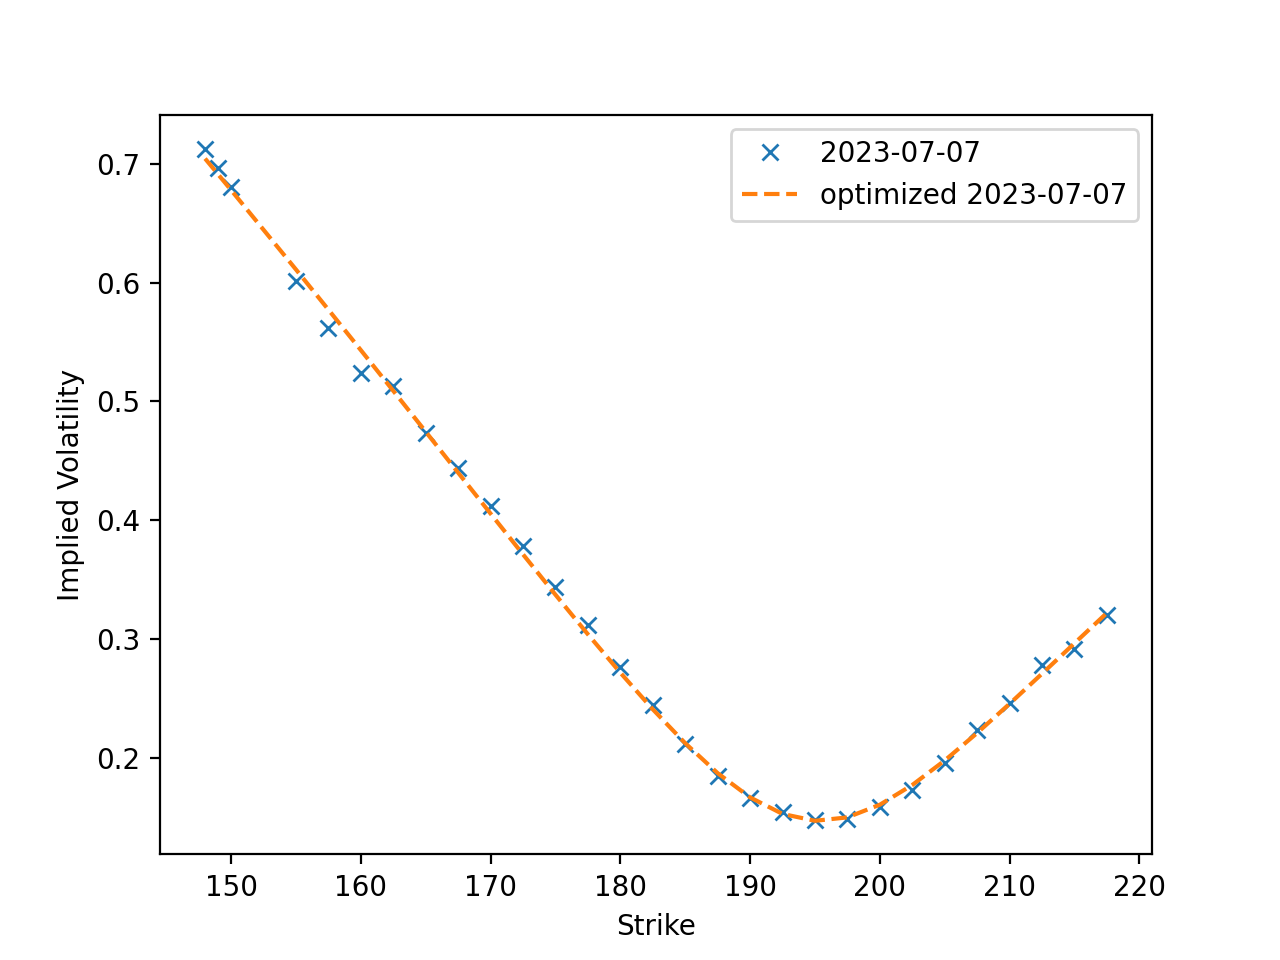

In [11]:
plot_date(fit_svi((0, 0.2), df_day[df_day['expiration'] == '2023-07-07']), '2023-07-07', df_day)

In [12]:
dates = df_day['expiration'].unique()

In [13]:
# parameters from quasi-explicit modified method
quasi_para = []
for date in dates:
    df_curr = df_day[df_day['expiration'] == date]
    para = fit_svi((0.01, 0.2), df_curr)
    quasi_para.append(para)

<IPython.core.display.Javascript object>


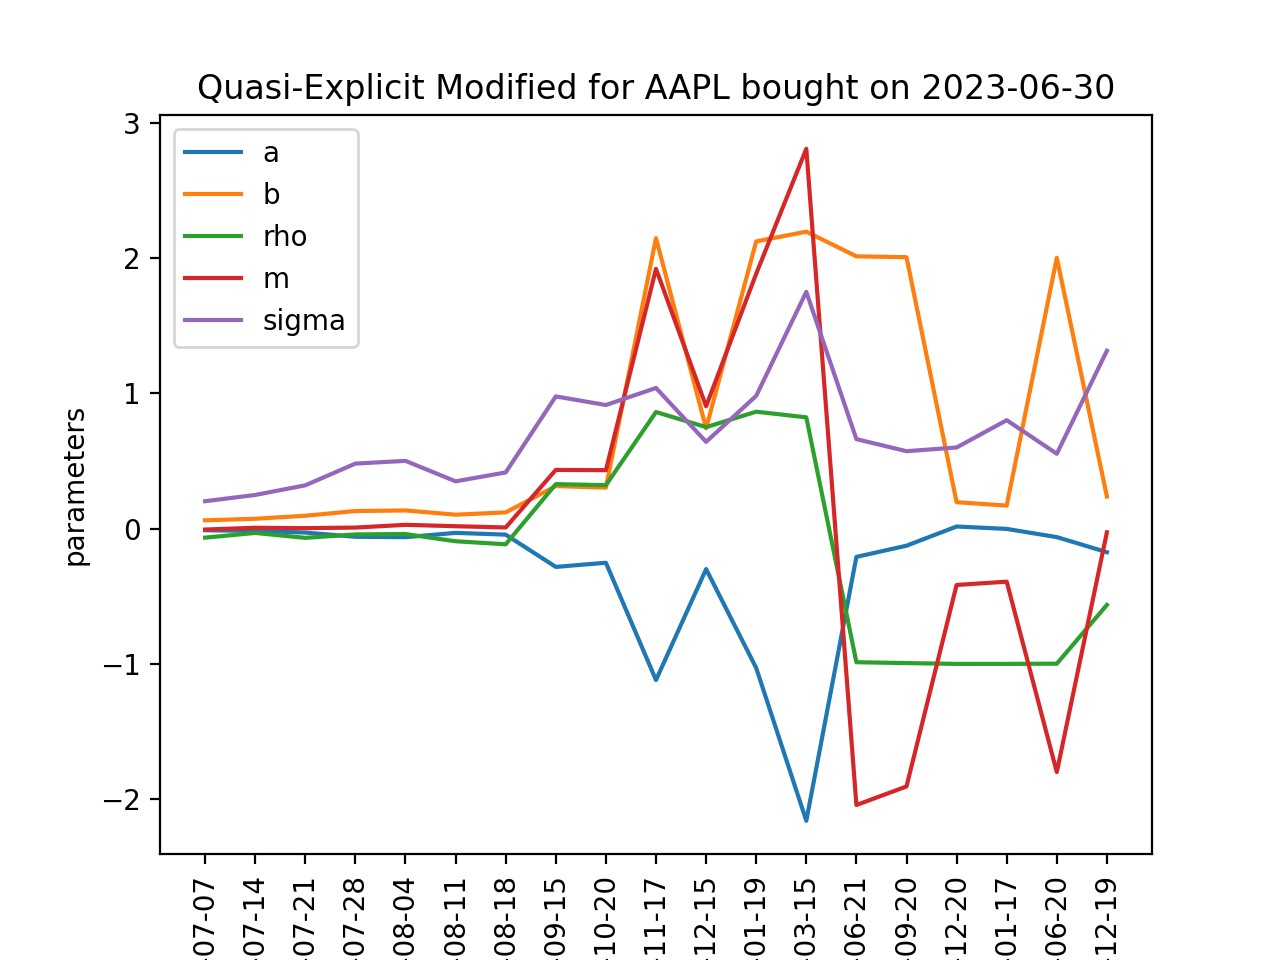

In [14]:
# behavior of the parameters
plt.plot(dates, quasi_para, '-', label = ['a', 'b', 'rho', 'm', 'sigma'])
plt.legend()
plt.ylabel('parameters')
plt.title('Quasi-Explicit Modified for AAPL bought on 2023-06-30')
plt.xticks(dates, rotation='vertical');

# Calendar Arbitrage

We can plot the total variance graph to see calendar arbitrage.

In [15]:
# plot total variance vs log-moneyness
def plot_total_var(para, date, df):
    a, b, rho, m, sig = para
    df_curr = df[df['expiration'] == date]
    x = df_curr['strike']
    y = df_curr['implied_vol']
    S = df_curr['adj_close'].iloc[0]
    T = df_curr['expiration_days'].iloc[0] / 365
    r = df_curr['disc_rate'].iloc[0]
    q = df_curr['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x_tilde = np.log(x / F_T)
    ans = a + b * (rho * (x_tilde - m) + np.sqrt((x_tilde - m) ** 2 + sig ** 2))
    plt.title('Total Variance for AAPL bought on 2023-06-30')
    plt.plot(x_tilde, ans, '-', label = date, linewidth=0.5)
    plt.xlabel('Log Moneyness k')
    plt.ylabel('Total Variance')
    plt.legend()

<IPython.core.display.Javascript object>


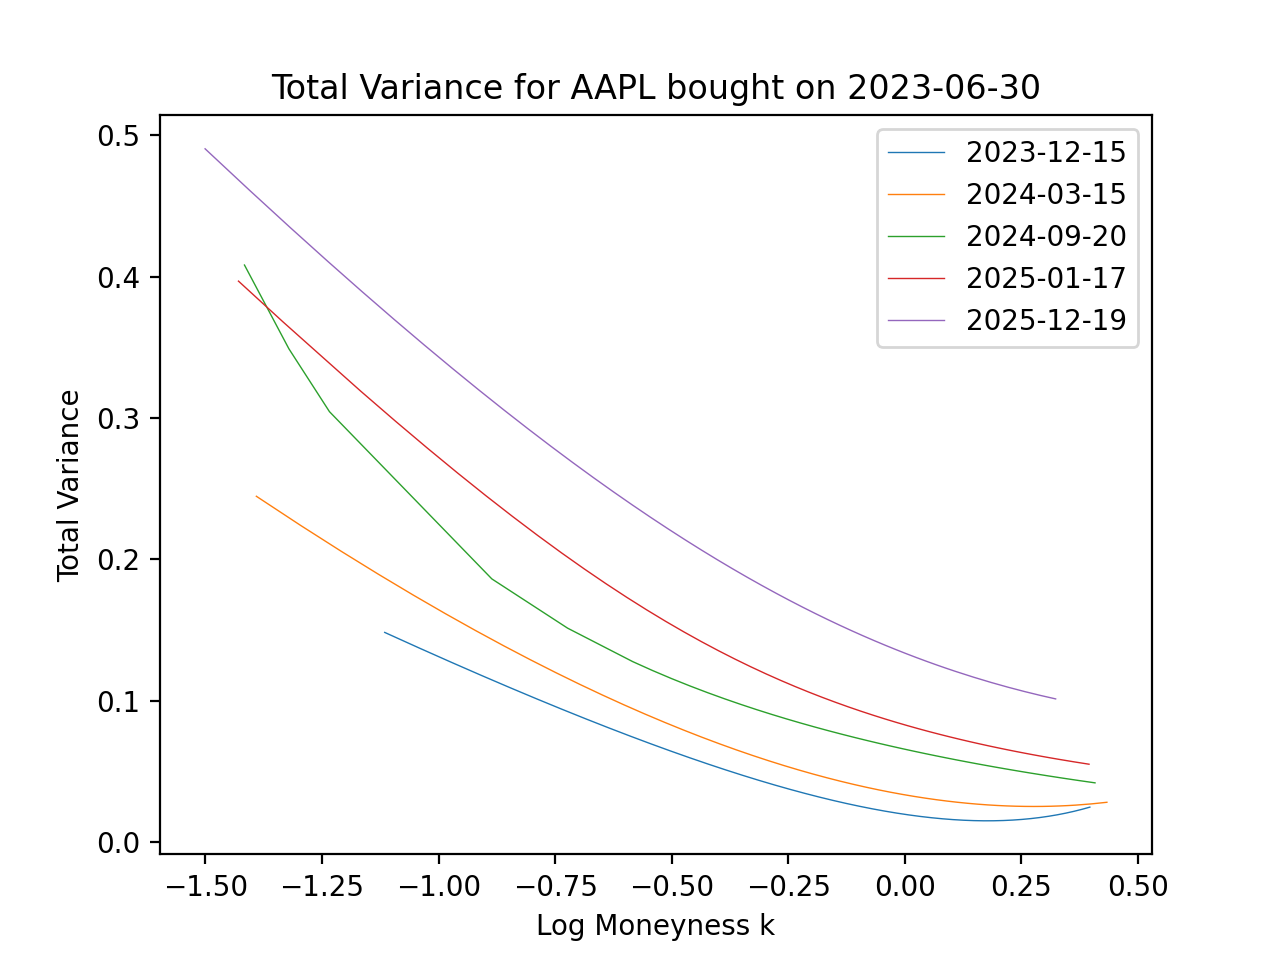

In [16]:
#list few of them so that the graph is not so dense
for date, para in list(zip(dates, quasi_para))[10::2]:
    plot_total_var(para, date, df_day)

We can see there is indeed an intersection between 2024-09-20 and 2025-01-17, which tells a calendar arbitrage.

# SSVI

In [17]:
# SSVI parametrization with phi(x) = eta / np.sqrt(x), this code is based on the R codes from Gatheral's lecture.
# Arbitrage free conditions are not posed in this code. But in most cases it will fit the conditions automaticallly.
def sviSqrt(sviSqrtParams, k, w0):
    rho = sviSqrtParams['rho']
    eta = sviSqrtParams['eta']
    w = w0/2 * (1 + rho * eta / np.sqrt(w0) * k + np.sqrt((eta / np.sqrt(w0) * k + rho) ** 2 + 1 - rho ** 2))
    return w

def stineman_slopes(x, y, scale=False):
    m = len(x)
    m1 = m - 1

    if m == 2:
        yp = np.repeat(np.diff(y) / np.diff(x), 2)
    else:
        if scale:
            sx = np.ptp(x)
            sy = np.ptp(y)
            if sy <= 0:
                sy = 1
            x = x / sx
            y = y / sy

        dx = np.diff(x)
        dy = np.diff(y)
        yp = np.full(m, np.nan)
        dx2dy2p = dx[1:] ** 2 + dy[1:] ** 2
        dx2dy2m = dx[:-1] ** 2 + dy[:-1] ** 2
        yp[1:m1] = (dy[:-1] * dx2dy2p + dy[1:] * dx2dy2m) / (dx[:-1] * dx2dy2p + dx[1:] * dx2dy2m)
        s = dy[0] / dx[0]
        if ((s >= 0 and s >= yp[1]) or (s <= 0 and s <= yp[1])):
            yp[0] = 2 * s - yp[1]
        else:
            yp[0] = s + abs(s) * (s - yp[1]) / (abs(s) + abs(s - yp[1]))
        s = dy[m1 - 1] / dx[m1 - 1]
        if ((s >= 0 and s >= yp[m1 - 1]) or (s <= 0 and s <= yp[m1 - 1])):
            yp[m1] = 2 * s - yp[m1 - 1]
        else:
            yp[m1] = s + abs(s) * (s - yp[m1 - 1]) / (abs(s) + abs(s - yp[m1 - 1]))

        if scale:
            yp = yp * sy / sx

    return yp

def stinterp(x, y, xout, yp=None, method="scaledstineman"):
    if x is None or y is None or xout is None:
        raise ValueError("Wrong number of input arguments, x, y, and xout must be specified")
#     if not isinstance(x, (np.ndarray, list)) or not isinstance(y, (np.ndarray, list)) or not isinstance(xout, (np.ndarray, list)) \
#             or not np.issubdtype(np.array(x).dtype, np.number) or not np.issubdtype(np.array(y).dtype, np.number) or not np.issubdtype(np.array(xout).dtype, np.number):
#         raise ValueError("x, y, and xout must be numeric vectors")
    #x, y, xout = np.array(x), np.array(y), np.array(xout)
    xout = np.array([xout])
    if len(x) < 2:
        raise ValueError("x must have 2 or more elements")
    if len(x) != len(y):
        raise ValueError("x must have the same number of elements as y")
    if np.any(np.isnan(x)) or np.any(np.isnan(y)) or np.any(np.isnan(xout)):
        raise ValueError("NAs in x, y, or xout are not allowed")
    if yp is not None:
        if not isinstance(yp, (np.ndarray, list)) or not np.issubdtype(np.array(yp).dtype, np.number):
            raise ValueError("yp must be a numeric vector")
        if len(y) != len(yp):
            raise ValueError("When specified, yp must have the same number of elements as y")
        if np.any(np.isnan(yp)):
            raise ValueError("NAs in yp are not allowed")
        if method is not None:
            raise ValueError("Method should not be specified if yp is given")

    dx = np.diff(x)
    dy = np.diff(y)
    if np.any(dx <= 0):
        raise ValueError("The values of x must be strictly increasing")

    if yp is None:
        if method == "scaledstineman":
            yp = stineman_slopes(x, y, scale=True)
        elif method == "stineman":
            yp = stineman_slopes(x, y, scale=False)
        elif method == "parabola":
            yp = parabola_slopes(x, y)

    m = len(x)
    m1 = m - 1
    s = dy / dx
    k = len(xout)
    ix = np.searchsorted(x, xout, side='right')
    epx = 5 * (np.finfo(float).eps) * np.ptp(x)
    ix[xout <= min(x) - epx] = 1
    ix[xout >= max(x) + epx] = m1
    idx = (ix >= 1) & (ix <= m1)
    ix1 = ix[idx]
    ix2 = ix1 + 1
    dxo1 = xout[idx] - x[ix1]
    dxo2 = xout[idx] - x[ix2-1]
    y0o = y[ix1] + s[ix1-1] * dxo1
    dyo1 = (yp[ix1] - s[ix1-1]) * dxo1
    dyo2 = (yp[ix2-1] - s[ix1-1]) * dxo2
    dyo1dyo2 = dyo1 * dyo2
    yo = y0o.copy()
    if m > 2 or yp is not None:
        id_1 = dyo1dyo2 > 0
        yo[id_1] = y0o[id_1] + dyo1dyo2[id_1] / (dyo1[id_1] + dyo2[id_1])
        id_2 = dyo1dyo2 < 0
        yo[id_2] = y0o[id_2] + dyo1dyo2[id_2] * (dxo1[id_2] + dxo2[id_2]) / (dyo1[id_2] - dyo2[id_2]) / (dx[ix1-1][id_2])

    yout = np.full(k, np.nan)
    yout[idx] = yo
    return {"x": xout, "y": yout}

def sviSqrtFit(ivolData):
   
    expDates = (np.unique(ivolData['expiration_days']))/365
    nSlices = len(expDates)
    sviMatrix = np.empty((nSlices, 5))
    nrows = ivolData.shape[0]
    midV = np.full(nrows, np.nan)
    kk = np.full(nrows, np.nan)
    ww0 = np.full(nrows, np.nan)

    # Compute w0, keeping k and midVar as we go
    for slice_idx in range(nSlices):
        t = expDates[slice_idx]
        texp = (ivolData['expiration_days'].to_numpy())/365
       
        midVar = ivolData['implied_vol'][texp == t].to_numpy()
        S0 = ivolData['adj_close'][texp == t].to_numpy()[0]
        r = ivolData['disc_rate'][texp == t].to_numpy()[0]
        q = ivolData['div_yield'][texp == t].to_numpy()[0]
        f = S0*np.exp((r-q)*t)
        k = (np.log(ivolData['strike'][texp == t] / f)).values
        w0 = t * stinterp(k,midVar**2, 0)['y']
        # Now put in the correct place in columns
        ww0[texp == t] = w0
        midV[texp == t] = midVar**2
        kk[texp == t] = k

    tcutoff = min(0.1, max(expDates))

    # Define objective function
    def obj(sviSqrtParams):
        sviSqrtParams = {'rho': sviSqrtParams[0], 'eta': sviSqrtParams[1]}
        sviSqrtVar = sviSqrt(sviSqrtParams, kk, ww0) / texp
        tmp = np.sum((midV - sviSqrtVar) ** 2)
        return tmp

    sviSqrtGuess = [-0.7, 1.0]
    bounds = [(-0.999, 0.999), (-np.inf, np.inf)]

    fit = minimize(obj, sviSqrtGuess, method="L-BFGS-B", bounds=bounds)
    res = fit.x

    # Now convert the result to an SVI matrix
    sel = ~np.isnan(ww0)
    w0r = np.unique(ww0[sel])
    rho = np.full(nSlices, res[0])
    a = w0r / 2 * (1 - rho ** 2)
    gg = res[1] / np.sqrt(w0r)
    b = w0r / 2 * gg
    m = -rho / gg
    sig = np.sqrt(1 - rho ** 2) / gg

    tmp = np.column_stack((a, b, rho, m, sig))
    return tmp

It is not hard to figure out the arbitrage conditions are $\eta\ge0$ and $(1+|\rho|)\cdot\eta\cdot\sqrt{\frac{w_{max}}{1+w_{max}}}\le4$ when we choose $\varphi(x)=\frac{\eta}{\sqrt{x(1+x)}}$, as long as the original data satisfies the increasing total variance condition. And we also use quasi-explicit modified method to estimate ATM total variance.

In [18]:
#SSVI parametrization with phi(x) = eta / np.sqrt(x * (1 + x)). Arbitrage conditions are posed.
def ssviSqrt(para, k, w0):
    rho, eta = para
    w = w0/2 * (1 + rho * eta / np.sqrt(w0 * (1 + w0)) * k + np.sqrt((eta / np.sqrt(w0 * (1 + w0)) * k + rho) ** 2 + 1 - rho ** 2))
    return w

def SSVI(df):
    expDates = np.unique(df['expiration_days'])
    nSlices = len(expDates)
    nrows = df.shape[0]
    midV = []
    kk = []
    ww0 = []
    theta0 = []
    # Compute w0, keeping k and midVar as we go
    for slice_idx in range(nSlices):
        t = expDates[slice_idx]
        df_curr = df[df['expiration_days'] == t]
        T = t / 365
        S = df_curr['adj_close'].iloc[0]
        r = df_curr['disc_rate'].iloc[0]
        q = df_curr['div_yield'].iloc[0]
        F_T = S * np.exp((r - q) * T)
        k = np.log(df_curr['strike'] / F_T)
        midVar = df_curr['implied_vol']
        a, b, rho, m, sig = fit_svi((0.1, 0.2), df_curr)
        w0 = a + b * (np.sqrt(m ** 2 + sig ** 2) - rho * m)
        ww0 = np.append(ww0, np.repeat(w0, len(df_curr)))
        midV = np.append(midV, midVar ** 2 * T)
        kk = np.append(kk, k)
        theta0.append(w0)

    def obj(para):
        total_variance = ssviSqrt(para, kk, ww0)
        tmp = np.sum((midV - total_variance) ** 2)
        return tmp
    
    w0_max = max(ww0)
    sviSqrtGuess = [0, 1.0]
    bounds = [(-1, 1), (0, np.inf)]
    cons=({'type': 'ineq', 'fun': lambda z: 4 - (1 + abs(z[0])) * z[1] * np.sqrt(w0_max / (1 + w0_max))})
    fit = minimize(obj, sviSqrtGuess, bounds=bounds, constraints=cons)
    rho, eta = fit.x
    # Now convert the result to an SVI matrix
    tmp = []
    for idx in range(nSlices):
        t = expDates[idx]
        df_curr = df[df['expiration_days'] == t]
        T = t / 365
        w0 = theta0[idx]
        sqrtw = np.sqrt(w0)
        phi = eta / np.sqrt(w0 * (1 + w0))
        vt = w0 / T
        psit = rho * sqrtw * phi / 2
        pt = sqrtw * phi * (1 - rho) / 2
        ct = sqrtw * phi * (1 + rho) / 2
        varmint = w0 / T * (1 - rho ** 2)
        tmp.append(jwToSvi(vt, psit, pt, ct, varmint, T))
    return tmp

def jwToSvi(vt, psit, pt, ct, varmint, texp):
    sqrtw = np.sqrt(vt * texp)
    bhat = (pt + ct) / 2
    b = bhat * sqrtw
    rho = 1 - pt / bhat
    bet = (rho - 2 * psit / bhat)
    alpha = np.sign(bet) * np.sqrt(1 / bet**2 - 1)
    m = (vt - varmint) * texp / (b * (-rho + np.sign(alpha) * np.sqrt(1 + alpha**2) - alpha * np.sqrt(1 - rho**2)))
    sig = alpha * m
    a = varmint * texp - b * sig * np.sqrt(1 - rho**2)
    return np.array([a, b, rho, m, sig])

def two_para_SSVI(df):
    expDates = np.unique(df['expiration_days'])
    nSlices = len(expDates)
    nrows = df.shape[0]
    midV = []
    kk = []
    ww0 = []
    theta0 = []
    # Compute w0, keeping k and midVar as we go
    for slice_idx in range(nSlices):
        t = expDates[slice_idx]
        df_curr = df[df['expiration_days'] == t]
        T = t / 365
        S = df_curr['adj_close'].iloc[0]
        r = df_curr['disc_rate'].iloc[0]
        q = df_curr['div_yield'].iloc[0]
        F_T = S * np.exp((r - q) * T)
        k = np.log(df_curr['strike'] / F_T)
        midVar = df_curr['implied_vol']
        a, b, rho, m, sig = fit_svi((0.1, 0.2), df_curr)
        w0 = a + b * (np.sqrt(m ** 2 + sig ** 2) - rho * m)
        ww0 = np.append(ww0, np.repeat(w0, len(df_curr)))
        midV = np.append(midV, midVar ** 2 * T)
        kk = np.append(kk, k)
        theta0.append(w0)

    def obj(para):
        total_variance = ssviSqrt(para, kk, ww0)
        tmp = np.sum((midV - total_variance) ** 2)
        return tmp
    
    w0_max = max(ww0)
    sviSqrtGuess = [0, 1.0]
    bounds = [(-1, 1), (0, np.inf)]
    cons=({'type': 'ineq', 'fun': lambda z: 4 - (1 + abs(z[0])) * z[1] * np.sqrt(w0_max / (1 + w0_max))})
    fit = minimize(obj, sviSqrtGuess, bounds=bounds, constraints=cons)
    return fit.x

In [19]:
SSVIfree_para = SSVI(df_day)

In [20]:
SSVI_para = sviSqrtFit(df_day)

<IPython.core.display.Javascript object>


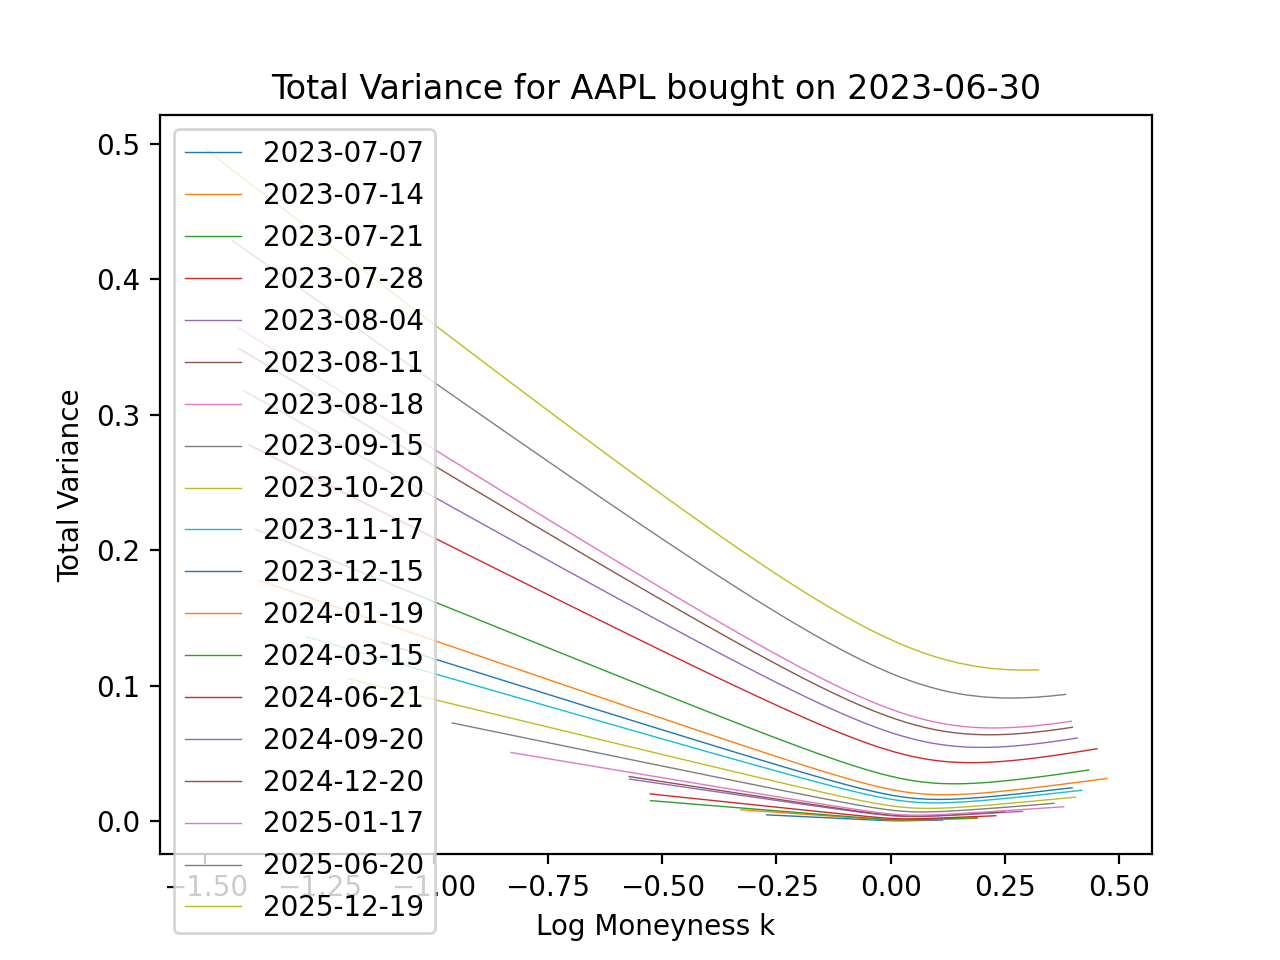

In [21]:
for date, para in zip(dates, SSVIfree_para):
    plot_total_var(para, date, df_day)

In [22]:
def ATM_total_variance(df):
    expDates = np.unique(df['expiration_days'])
    nSlices = len(expDates)
    theta0 = []
    for slice_idx in range(nSlices):
        t = expDates[slice_idx]
        df_curr = df[df['expiration_days'] == t]
        T = t / 365
        S = df_curr['adj_close'].iloc[0]
        r = df_curr['disc_rate'].iloc[0]
        q = df_curr['div_yield'].iloc[0]
        F_T = S * np.exp((r - q) * T)
        k = np.log(df_curr['strike'] / F_T)
        a, b, rho, m, sig = fit_svi((0.1, 0.2), df_curr)
        w0 = a + b * (np.sqrt(m ** 2 + sig ** 2) - rho * m)
        theta0.append(w0)
    return theta0

# We use cubic polynomial to fit the ATM total variance.
def ATM_cf(df):
    T = np.unique(df['expiration_days'])
    y = ATM_total_variance(df)
    def test(x, a, b, c, d):
        return a * x ** 3 + b * x ** 2 + c * x + d
    s, _ = curve_fit(test, T, y)
    return s

In [23]:
#surface plot
def ssvi_ev(K, T, S, r, q, para, para2):
    a, b, c, d = para2
    w0 = a * T ** 3 + b * T ** 2 + c * T + d
    t = T / 365
    F_T = S * np.exp((r - q) * t)
    x_tilde = np.log(K / F_T)
    return np.sqrt(ssviSqrt(para, x_tilde, w0) / t)

def plot_ssvi_surface(df):
    para = two_para_SSVI(df)
    para2 = ATM_cf(df)
    S = df['adj_close'].iloc[0]
    r = df['disc_rate'].iloc[0]
    q = df['div_yield'].iloc[0]
    x = np.linspace(50, 400, 100)
    y = np.linspace(1, 900, 100)
    x, y = np.meshgrid(x, y)
    z = ssvi_ev(x, y, S, r, q, para, para2)
    fig = plt.figure(figsize=(10, 7)) 
    axes = fig.add_subplot(projection='3d')
    axes.plot_surface(x, y, z, cmap='viridis')
    plt.title('AAPL Options bought on 2023-06-30')
    axes.set_xlabel('Strike')
    axes.set_ylabel('Expiration days')
    axes.set_zlabel('Implied Volatility')
    axes.view_init(30, 60)
    plt.show()

/var/folders/ly/fh5l0xkd6dv9fqx4n4gc1sh00000gn/T/ipykernel_1944/90179141.py:4: RuntimeWarning: invalid value encountered in sqrt
  w = w0/2 * (1 + rho * eta / np.sqrt(w0 * (1 + w0)) * k + np.sqrt((eta / np.sqrt(w0 * (1 + w0)) * k + rho) ** 2 + 1 - rho ** 2))


<IPython.core.display.Javascript object>


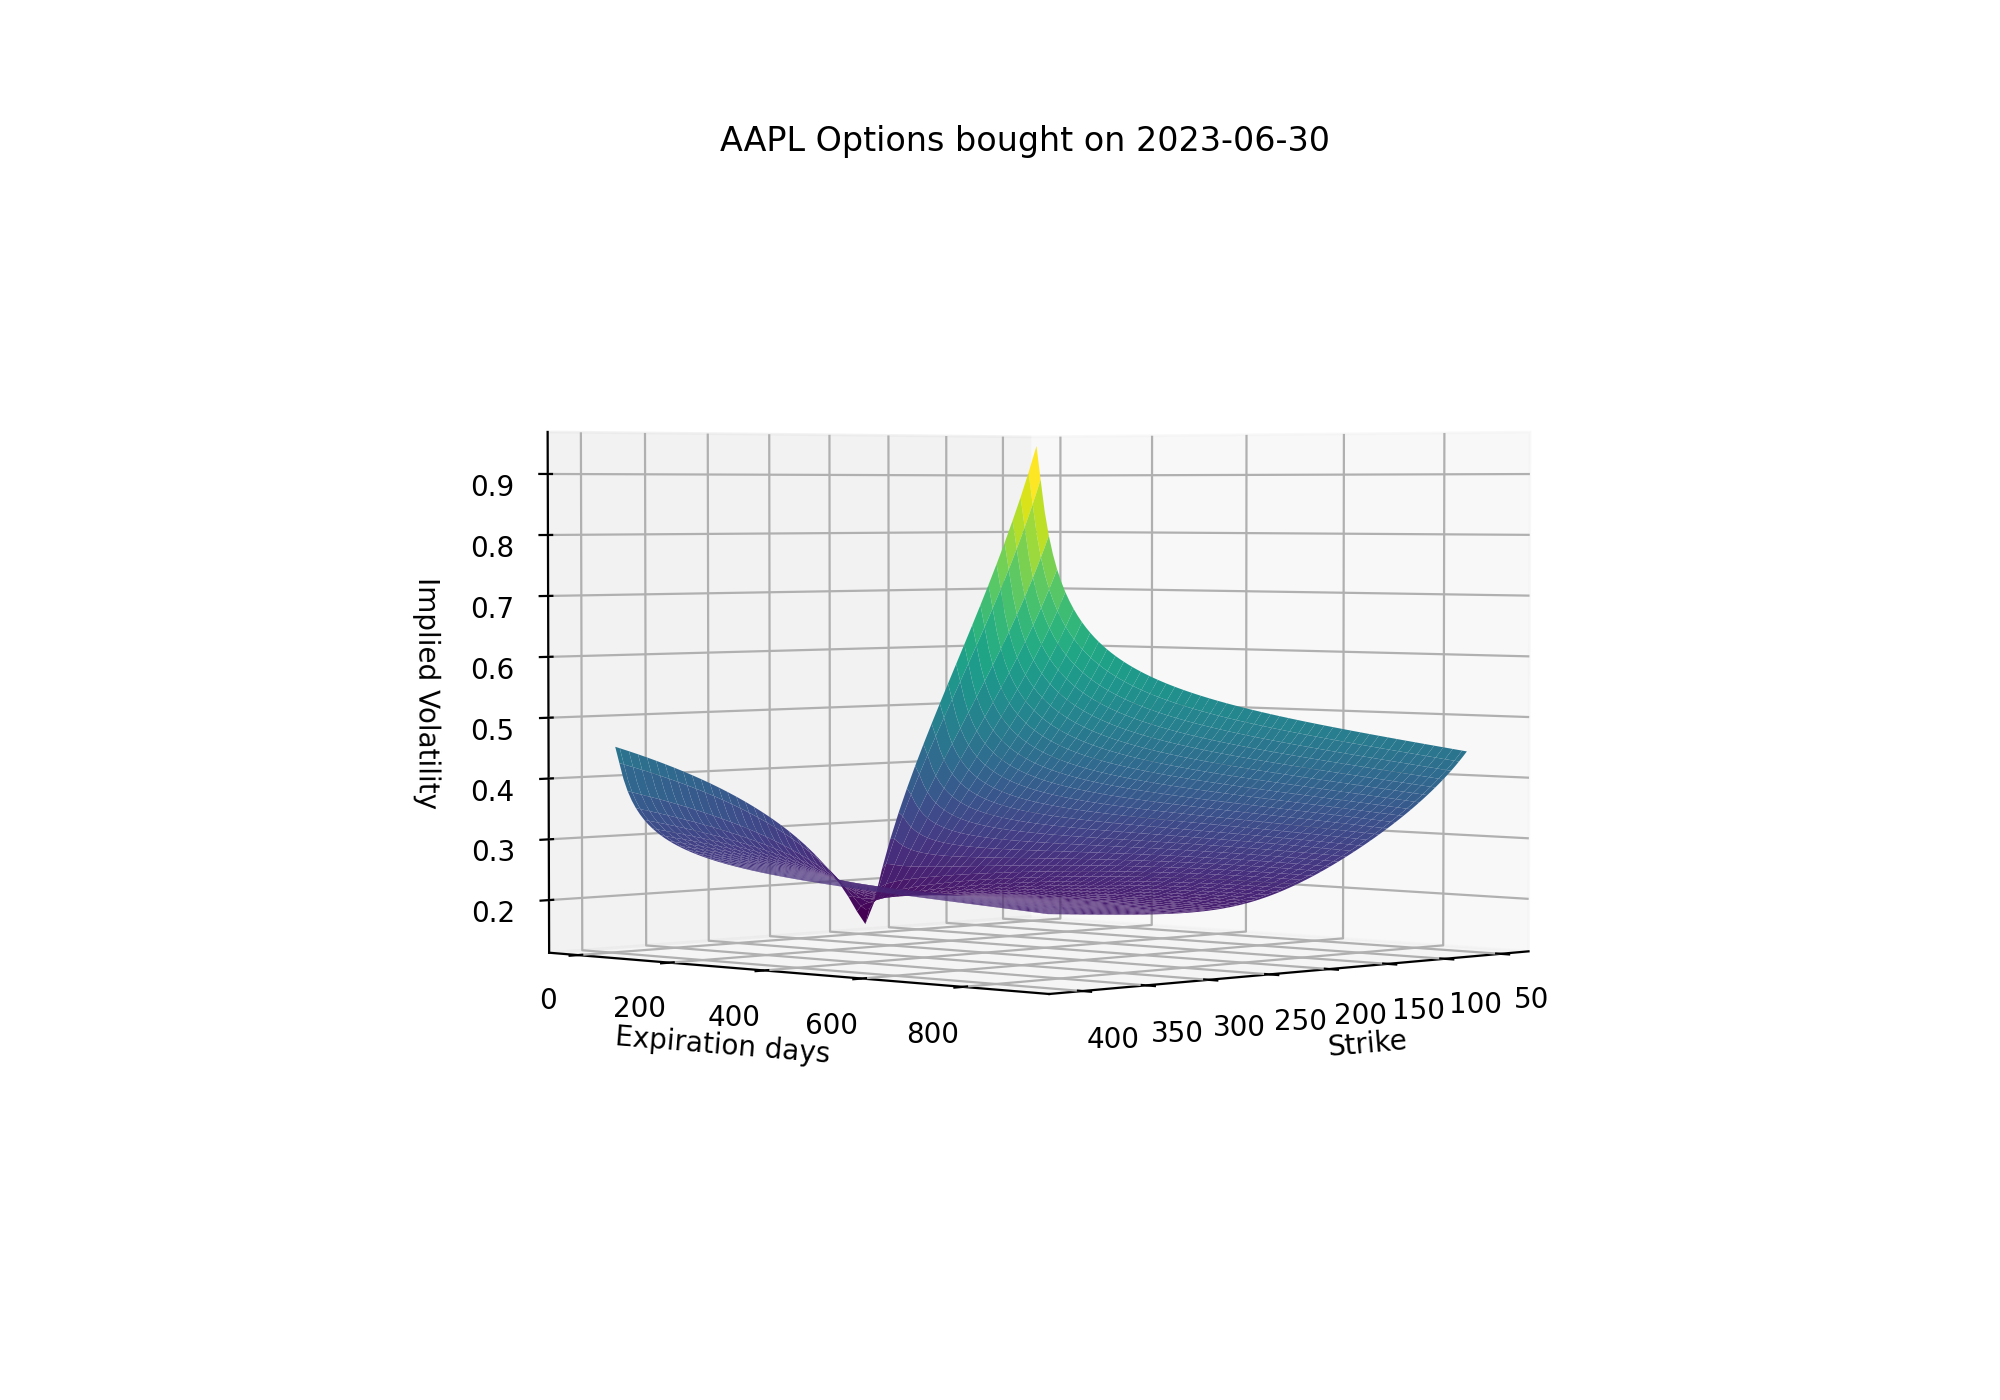

In [24]:
plot_ssvi_surface(df_day)

In [25]:
def RMSE(para, date, df):
    a, b, rho, m, sig = para
    df_curr = df[df['expiration'] == date]
    x = df_curr['strike']
    y = df_curr['implied_vol']
    S = df_curr['adj_close'].iloc[0]
    T = df_curr['expiration_days'].iloc[0] / 365
    r = df_curr['disc_rate'].iloc[0]
    q = df_curr['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x_tilde = np.log(x / F_T)
    ans = np.sqrt((a + b * (rho * (x_tilde - m) + np.sqrt((x_tilde - m) ** 2 + sig ** 2))) / T)
    res = 0
    for i, j in zip(y, ans):
        res += (i - j) ** 2
    return np.sqrt(res / (len(y)))

In [26]:
RMSE_SSVIfree = []
for date, para in zip(dates, SSVIfree_para):
    RMSE_SSVIfree.append(RMSE(para, date, df_day))

In [27]:
RMSE_SSVI = []
for date, para in zip(dates, SSVI_para):
    RMSE_SSVI.append(RMSE(para, date, df_day))

<IPython.core.display.Javascript object>


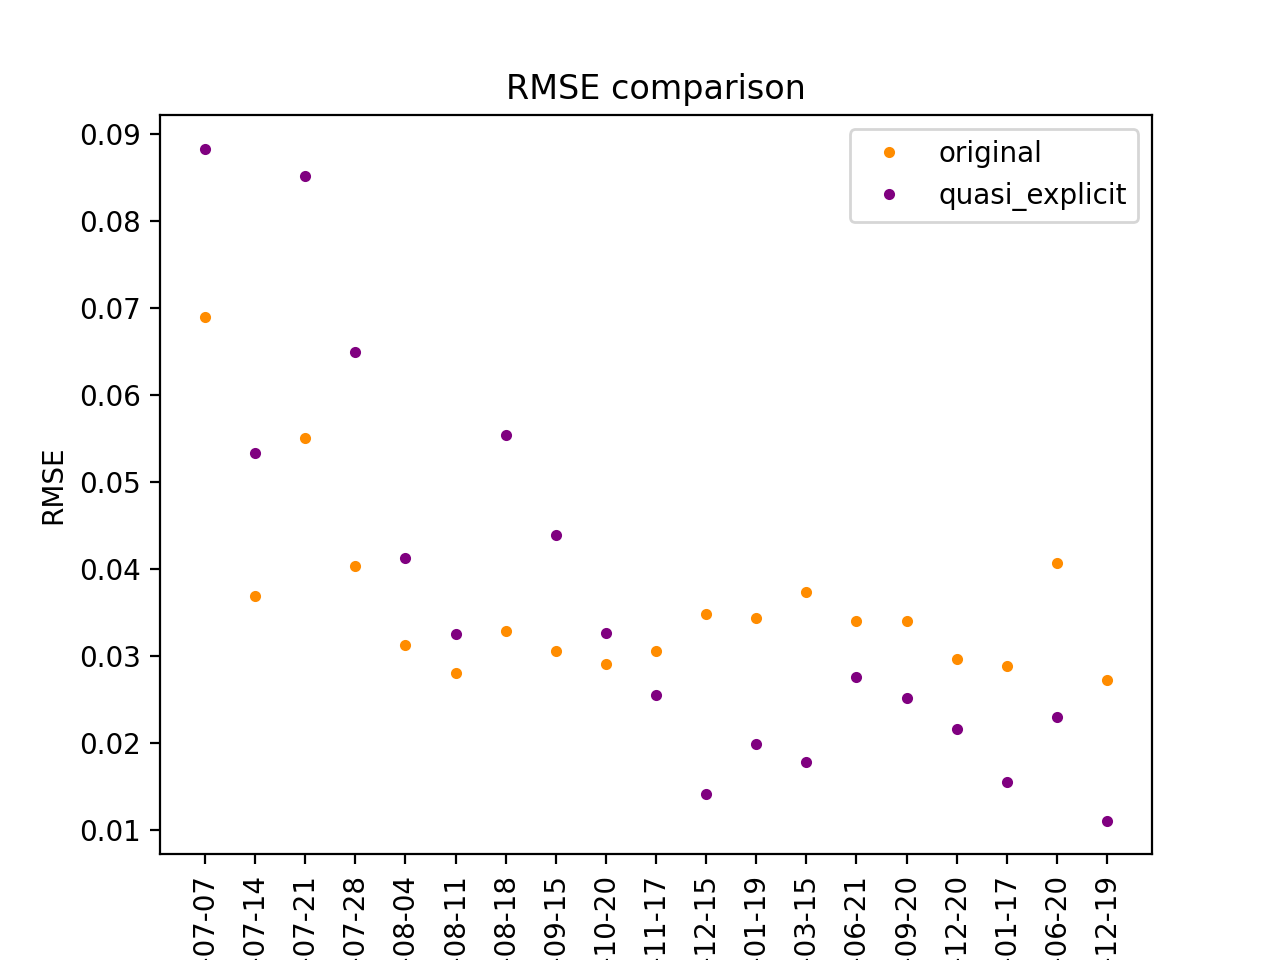

In [28]:
plt.title('RMSE comparison')
plt.plot(dates, RMSE_SSVI, '.', label = 'original', color = 'darkorange')
plt.plot(dates, RMSE_SSVIfree, '.', label = 'quasi_explicit', color = 'purple')
plt.legend()
plt.ylabel('RMSE')
plt.xticks(dates, rotation='vertical');

# Crossedness

We use the crossedness idea in Gatheral's paper. Instead of considering the option price, we directly use the total variance. The implementation suggested in the paper does not quite work. Therefore, we use another method to measure the crossedness.

In [29]:
def svi(para, x):
    a, b, rho, m, sig = para
    return a + b * (rho * (x - m) + np.sqrt((x - m) ** 2 + sig ** 2))

#sviGuess is the initial guess for parameters, here we use quasi-explicit modified to get initial guess
def svi_cross(df, sviGuess, penaltyFactor=100):
    expDates = np.unique(df['expiration_days'])
    nSlices = len(expDates)
    sviMatrix = []

    def sqDist(sviparams, S, K, T, r, q, tot):
        F_T = S * np.exp((r - q) * T)
        x = np.log(K / F_T)
        predict = svi(sviparams, x)
        return np.sum((tot - predict) ** 2)

    def sqDistN(sviparams, S, K, T, r, q, tot, idx):
        return sqDist(sviparams, S, K, T, r, q, tot) / sqDist(sviGuess[idx], S, K, T, r, q, tot)

    def crossPenalty(sviparams, penaltyFactor, low_K, high_K):
        # Compare with previous slice
        prev = [sviparams]
        prev.append(sviMatrix[-1])
        cPenalty = svi_check(prev, low_K, high_K)

        return cPenalty * penaltyFactor

    
    sviMatrix.append(sviGuess[-1])
    for idx in range(nSlices - 2, -1, -1):
        t = expDates[idx]
        df_curr = df[df['expiration_days'] == t]
        S = df_curr['adj_close'].iloc[0]
        r = df_curr['disc_rate'].iloc[0]
        q = df_curr['div_yield'].iloc[0]
        K = df_curr['strike']
        T = t / 365
        tot = df_curr['implied_vol'] ** 2 * T
        F_T = S * np.exp((r - q) * T)
        low_x = np.log((min(K) - 5) / F_T)
        high_x = np.log((max(K) - 5) / F_T)
        def penalty_func(sviparams, S, K, T, r, q, tot, idx, penaltyFactor, low_K, high_K):
            return sqDistN(sviparams, S, K, T, r, q, tot, idx) + crossPenalty(sviparams, penaltyFactor, low_K, high_K)

        fit = minimize(penalty_func, sviGuess[idx], args=(S, K, T, r, q, tot, idx, penaltyFactor, low_x, high_x), method='BFGS')
        sviMatrix.append(fit.x)

        if abs(fit.x[2]) > 1:  # Only send to L-BFGS-B if rho is outside the permitted range
            fit = minimize(penalty_func, sviGuess[idx], args=(S, K, T, r, q, tot, idx, penaltyFactor, low_x, high_x), method='L-BFGS-B', bounds=((-1000, 1000), (0, 100), (-1, 1), (-10, 10), (0.00000001, 100)))
            sviMatrix[-1] = fit.x
            
    sviMatrix.reverse()
    return sviMatrix

def svi_check(prev, l, r):
    x = np.linspace(l - 0.2, r + 0.2, 1000)
    crossedness = 0
    for samplePoint in x: 
        sviShort = svi(prev[0], samplePoint)
        sviLong = svi(prev[1], samplePoint)
        crossedness = max(crossedness, sviShort - sviLong)
    return crossedness

In [30]:
cross_para_100 = svi_cross(df_day, np.array(quasi_para), 100)

In [31]:
RMSE_100 = []
for date, para in list(zip(dates, cross_para_100)):
    RMSE_100.append(RMSE(para, date, df_day))

<IPython.core.display.Javascript object>


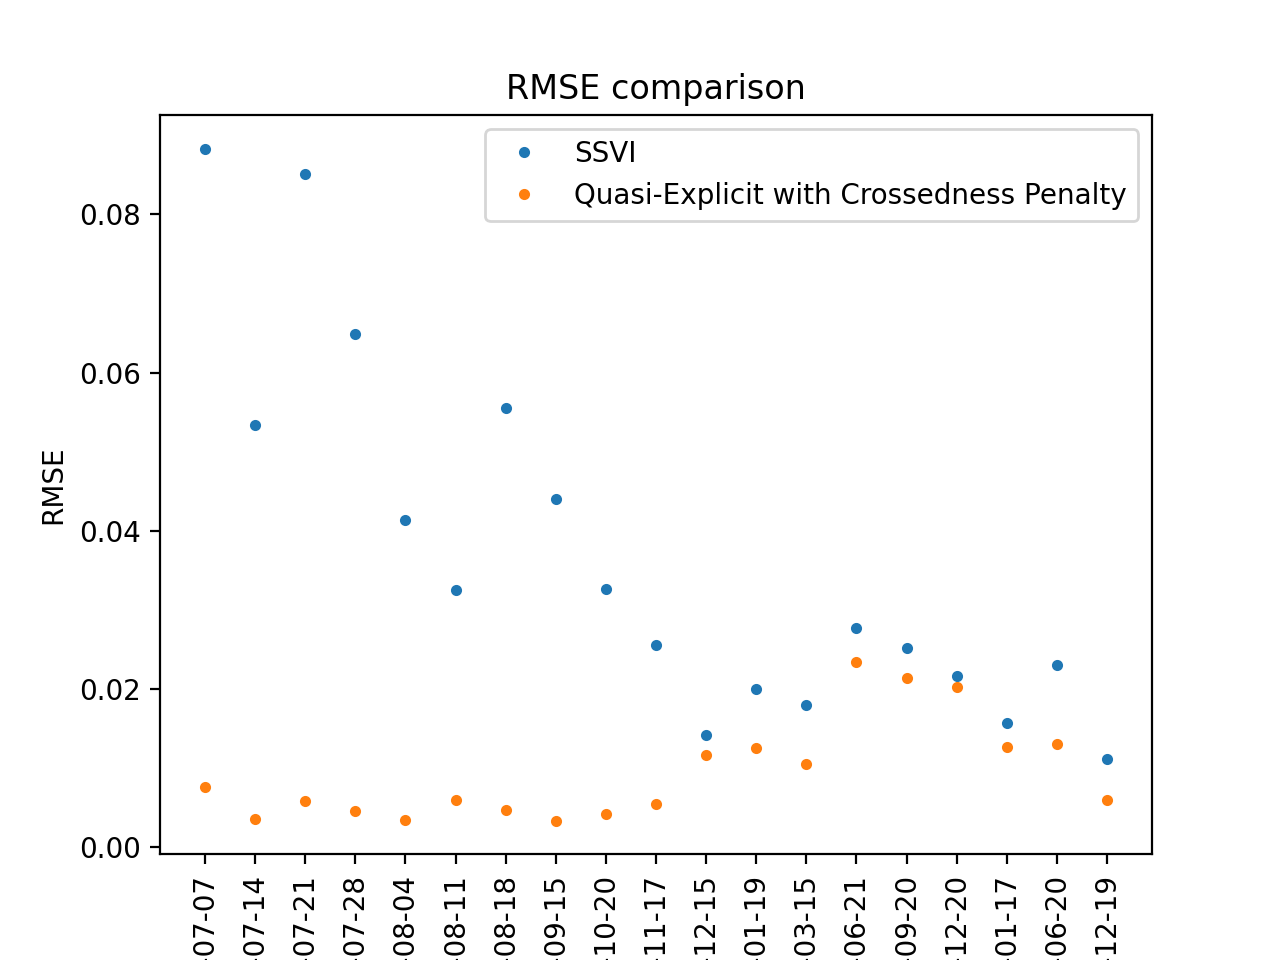

In [32]:
plt.title('RMSE comparison')
plt.plot(dates, RMSE_SSVIfree, '.', label = 'SSVI')
plt.plot(dates, RMSE_100, '.', label = 'Quasi-Explicit with Crossedness Penalty')
plt.legend()
plt.ylabel('RMSE')
plt.xticks(dates, rotation='vertical');

In [33]:
# build a dictionary to do 3D plot
quasi_para = {}
t_arr = []
for dd, para in zip(df_day['expiration_days'].unique(), cross_para_100):
    t_arr.append(dd)
    quasi_para[dd] = para

In [34]:
@np.vectorize
def svi_ev(K, T):
    a, b, rho, m, sig = quasi_para[T]
    df_curr = df_day[df_day['expiration_days'] == T]
    S = df_curr['adj_close'].iloc[0]
    T /= 365
    r = df_curr['disc_rate'].iloc[0]
    q = df_curr['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x_tilde = np.log(K / F_T)
    return np.sqrt((a + b * (rho * (x_tilde - m) + np.sqrt((x_tilde - m) ** 2 + sig ** 2))) / T)

<IPython.core.display.Javascript object>


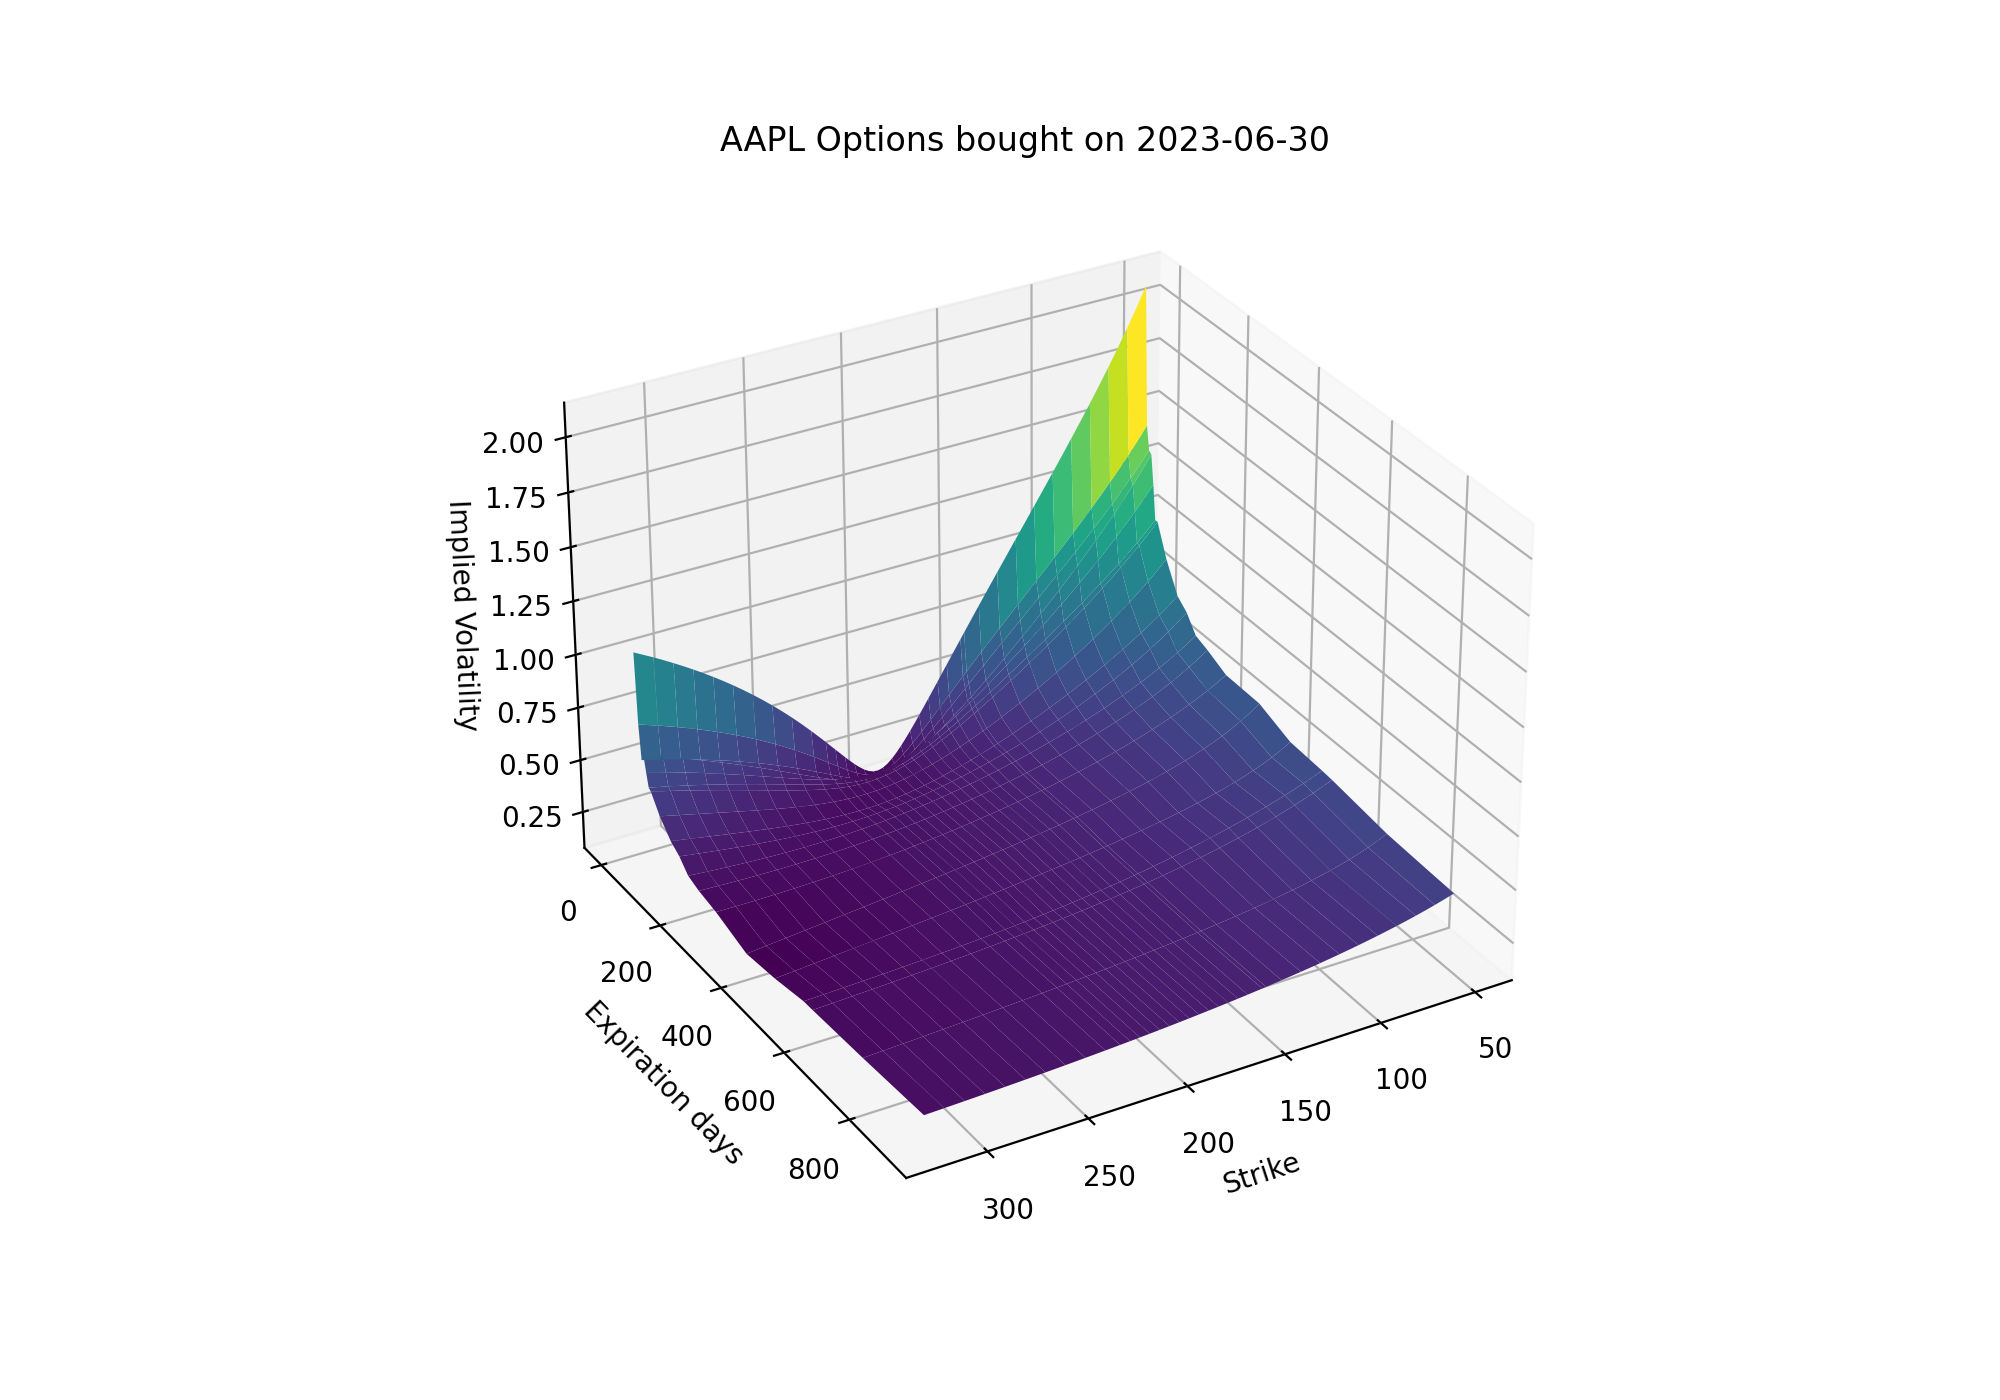

In [35]:
x = sorted(df_day['strike'].unique())
y = t_arr
x, y = np.meshgrid(x, y)
z = svi_ev(x, y)
fig = plt.figure(figsize=(10, 7)) 
axes = fig.add_subplot(projection='3d')
axes.plot_surface(x, y, z, cmap='viridis')
plt.title('AAPL Options bought on 2023-06-30')
axes.set_xlabel('Strike')
axes.set_ylabel('Expiration days')
axes.set_zlabel('Implied Volatility')
axes.view_init(30, 60)
plt.show()